# Punto 3 - Regresion - Miguel Rios Tangarife

Librerias que vamos a utilizar

In [48]:
import glob
from PIL import Image
import random
import matplotlib.image as img
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
from datetime import date
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

Leemos los datos

In [49]:
df = pd.read_excel('data/Saber_icfes_XLSX.xlsx')

Al usar "df" vemos que tenemos 68725 rows × 96 columns en un inicio

In [29]:
#df

## Sobre nulos...

Antes de analizar y filtrar aquellos variables que son más relevantes para el modelo, considero importante tener control sobre los valores nulos

Primero abordemos las variables numericas

In [3]:
df.fillna(df['PERIODO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_RESIDE_DEPTO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_RESIDE_MCPIO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_COLE_MCPIO_TERMINO'].mean(), inplace=True)
df.fillna(df['ESTU_SNIES_PRGMACADEMICO'].mean(), inplace=True)
df.fillna(df['ESTU_PRGM_CODMUNICIPIO'].mean(), inplace=True)
df.fillna(df['ESTU_INST_CODMUNICIPIO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_MCPIO_PRESENTACION'].mean(), inplace=True)
df.fillna(df['ESTU_COD_DEPTO_PRESENTACION'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITAT_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITATIVO_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITATIVO_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_COMPETEN_CIUDADA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_COMPETEN_CIUDADA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_DESEM'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PNBC'].mean(), inplace=True)
df.fillna(df['PUNT_GLOBAL'].mean(), inplace=True)
df.fillna(df['PERCENTIL_GLOBAL'].mean(), inplace=True)
df.fillna(df['PERCENTIL_NBC'].mean(), inplace=True)

Verifiquemos que si se hayan manejado adecuadamente los nulos

In [4]:
numeric_variables = df.select_dtypes(include=['number'])
hay_valores_nulos_numericas = numeric_variables.isnull().any().any()
if hay_valores_nulos_numericas:
    print("Hay valores nulos en las variables numéricas.")
else:
    print("No hay valores nulos en las variables numéricas.")

No hay valores nulos en las variables numéricas.


Abordemos los nulos o vacios en las variables categoricas, una opcion es eliminando las filas de la columna donde se enceuntren dichos valores...

## ¿Qué variables son importantes para predecir el valor?

Para esto analizaremos primero como se comporta la correlacion con variables numericas

In [5]:
numeric_columns = df.select_dtypes(include=['number'])

# Calcular la correlación de Pearson entre las columnas numéricas y la variable objetivo
correlation_matrix = numeric_columns.corr(method='pearson')  # Método de Pearson

# Mostrar la correlación con la variable objetivo
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print(correlation_with_target)

MOD_INGLES_PUNT                 1.000000
MOD_INGLES_PNAL                 0.355438
PERCENTIL_GLOBAL                0.354807
MOD_COMPETEN_CIUDADA_PNAL       0.354486
MOD_LECTURA_CRITICA_PNAL        0.354288
MOD_INGLES_PNBC                 0.354236
MOD_RAZONA_CUANTITATIVO_PNAL    0.354134
PERCENTIL_NBC                   0.353608
MOD_COMPETEN_CIUDADA_PNBC       0.353296
MOD_LECTURA_CRITICA_PNBC        0.353089
MOD_RAZONA_CUANTITATIVO_PNBC    0.352938
MOD_COMUNI_ESCRITA_PNAL         0.134877
MOD_COMUNI_ESCRITA_PNBC         0.134796
PUNT_GLOBAL                     0.034244
MOD_COMPETEN_CIUDADA_PUNT       0.033020
MOD_LECTURA_CRITICA_PUNT        0.026229
MOD_RAZONA_CUANTITAT_PUNT       0.016171
MOD_COMUNI_ESCRITA_DESEM        0.010052
ESTU_CODDANE_COLE_TERMINO       0.004917
ESTU_COD_RESIDE_MCPIO           0.003260
MOD_COMUNI_ESCRITA_PUNT         0.002416
ESTU_INST_CODMUNICIPIO          0.000485
INST_COD_INSTITUCION            0.000420
ESTU_COD_RESIDE_DEPTO          -0.000175
ESTU_SNIES_PRGMA

Observamos que las variables con un valor o tendencia a 0 son las que menor impacto tienen sobre la variable objetivo, por lo tanto pueden ser consideradas para eliminarse.

Lista de variables con correlación débil(cercana a 0)

- MOD_COMUNI_ESCRITA_PNAL: 0.134877
- MOD_COMUNI_ESCRITA_PNBC: 0.13479  
- PUNT_GLOBAL: 0.034244
- MOD_COMPETEN_CIUDADA_PUNT: 0.033020
- MOD_LECTURA_CRITICA_PUNT: 0.026229
- MOD_RAZONA_CUANTITAT_PUNT: 0.016171
- MOD_COMUNI_ESCRITA_DESEM: 0.010052
- ESTU_CODDANE_COLE_TERMINO: 0.004917
- ESTU_COD_RESIDE_MCPIO: 0.003260
- MOD_COMUNI_ESCRITA_PUNT: 0.002416
- ESTU_INST_CODMUNICIPIO: 0.000485
- INST_COD_INSTITUCION: 0.000420
- ESTU_COD_RESIDE_DEPTO: -0.000175
- ESTU_SNIES_PRGMACADEMICO: -0.000520
- ESTU_COD_COLE_MCPIO_TERMINO: -0.001509
- ESTU_COD_DEPTO_PRESENTACION: -0.003585
- ESTU_COD_MCPIO_PRESENTACION: -0.003592
- ESTU_PRGM_CODMUNICIPIO: -0.004483ICIPIO: -0.004483

Una vez analizadas las variables numericas, abordemos las variables categoricas

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [7]:
categorical_columns

Index(['ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO',
       'ESTU_FECHANACIMIENTO', 'ESTU_EXTERIOR', 'ESTU_CONSECUTIVO',
       'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_DISC_FISICA',
       'ESTU_DISC_SISTEM', 'ESTU_DISC_AUDITCASTELL', 'ESTU_DISC_AUDITLSC',
       'ESTU_DISC_VISUALCEGUE', 'ESTU_DISC_VISUALBAJA', 'ESTU_DISC_VOZHABLA',
       'ESTU_DISC_INTELEC', 'ESTU_DISC_ESPAUTISTA', 'ESTU_DISC_PSICOSOCIAL',
       'ESTU_DISC_ASPERGER', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE',
       'ESTU_AREARESIDE', 'ESTU_ESTADOCIVIL', 'ESTU_COLE_TERMINO',
       'ESTU_OTROCOLE_TERMINO', 'ESTU_TITULOOBTENIDOBACHILLER',
       'ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULACREDITO',
       'ESTU_PAGOMATRICULAPADRES', 'ESTU_PAGOMATRICULAPROPIO',
       'ESTU_COMOCAPACITOEXAMENSB11', 'ESTU_TIPODOCUMENTOSB11',
       'ESTU_SEMESTRECURSA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
       'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTE

Mirando los datos en excel podemos determinar que aquellas variables categóricas que tienen el mismo valor en todas sus filas o en la gran mayoria y no aportan información variada podemos descartarlas.

Lista de variables categoricas que tienen el mismo valor en todas sus filas:
- ESTU_EXTERIOR
- PERIODO
- ESTU_ESTUDIANTE
- ESTU_PRIVADO_LIBERTAD

In [8]:
variables_categoricas = [
    'ESTU_TIPODOCUMENTO'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT           1.000000
ESTU_TIPODOCUMENTO_PE     0.001248
ESTU_TIPODOCUMENTO_TI     0.001113
ESTU_TIPODOCUMENTO_CE     0.001027
ESTU_TIPODOCUMENTO_PEP   -0.000051
ESTU_TIPODOCUMENTO_CR    -0.000325
Name: MOD_INGLES_PUNT, dtype: float64


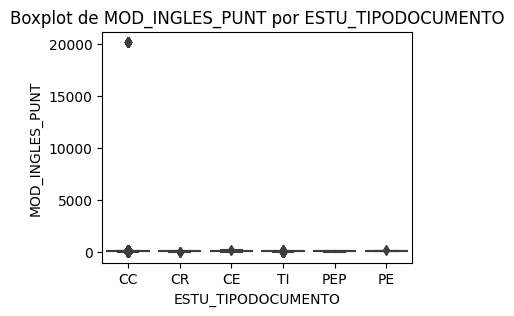

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
variables_categoricas = ['ESTU_TIPODOCUMENTO']
variables_de_interes = ['MOD_INGLES_PUNT']
df_subset = df[variables_categoricas + variables_de_interes]

# Crea un boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(x='ESTU_TIPODOCUMENTO', y='MOD_INGLES_PUNT', data=df_subset)
plt.xlabel('ESTU_TIPODOCUMENTO')
plt.ylabel('MOD_INGLES_PUNT')
plt.title('Boxplot de MOD_INGLES_PUNT por ESTU_TIPODOCUMENTO')
plt.show()

En el caso de la variable categorica 'ESTU_TIPODOCUMENTO', observamos que por su correlacion no tiene gran impacto sobre la variable objetivo, además en el boxplot podemos ver una relacion simular entre todos los tipos de documentos menos por PE(Permiso Especial de Permanencia) del cual solo hay 4 registros en todos los datos de esa columna, es por eso que no afecta a la variable objetivo esta variable categorica.

De aqui en adelante usaré la correlación o el boxplot para analizar las dummie variables y el analisis manual de cada variable para decidir

In [10]:
variables_categoricas = [
    'ESTU_NACIONALIDAD'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT                           1.000000
ESTU_NACIONALIDAD_VENEZUELA               0.001300
ESTU_NACIONALIDAD_EL SALVADOR             0.001292
ESTU_NACIONALIDAD_MÉXICO                  0.000443
ESTU_NACIONALIDAD_REPÚBLICA DOMINICANA    0.000318
ESTU_NACIONALIDAD_ECUADOR                 0.000279
ESTU_NACIONALIDAD_PERÚ                    0.000271
ESTU_NACIONALIDAD_ESTADOS UNIDOS          0.000239
ESTU_NACIONALIDAD_PANAMÁ                  0.000185
ESTU_NACIONALIDAD_ANTIGUA Y BARBUDA       0.000180
ESTU_NACIONALIDAD_CHILE                   0.000158
ESTU_NACIONALIDAD_HAITI                   0.000004
ESTU_NACIONALIDAD_BOLIVIA                -0.000098
ESTU_NACIONALIDAD_ESPAÑA                 -0.000239
ESTU_NACIONALIDAD_CANADÁ                 -0.000308
ESTU_NACIONALIDAD_NICARAGUA              -0.000553
ESTU_NACIONALIDAD_COLOMBIA               -0.001466
Name: MOD_INGLES_PUNT, dtype: float64


Por valores de correlación se descarta, hay mayoria de colombianos y venezolanos

In [11]:
variables_categoricas = [
    'ESTU_GENERO'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT    1.000000
ESTU_GENERO_M      0.002357
ESTU_GENERO_F     -0.002279
Name: MOD_INGLES_PUNT, dtype: float64


In [12]:
variables_categoricas = [
    'ESTU_DISC_FISICA'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT       1.000000
ESTU_DISC_FISICA_x   -0.000736
Name: MOD_INGLES_PUNT, dtype: float64


Los estudiantes que poseen alguna discapacidad son pocos por ende no influye mucho en el modelo.

In [13]:
variables_categoricas = [
    'ESTU_DEPTO_RESIDE'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT                      1.000000
ESTU_DEPTO_RESIDE_SUCRE              0.031402
ESTU_DEPTO_RESIDE_BOGOTÁ             0.011027
ESTU_DEPTO_RESIDE_CASANARE           0.008056
ESTU_DEPTO_RESIDE_QUINDIO            0.005703
ESTU_DEPTO_RESIDE_RISARALDA          0.005490
ESTU_DEPTO_RESIDE_SANTANDER          0.001003
ESTU_DEPTO_RESIDE_HUILA              0.000267
ESTU_DEPTO_RESIDE_EXTRANJERO         0.000131
ESTU_DEPTO_RESIDE_BOYACA             0.000092
ESTU_DEPTO_RESIDE_ATLANTICO          0.000021
ESTU_DEPTO_RESIDE_SAN ANDRES        -0.000048
ESTU_DEPTO_RESIDE_VALLE             -0.000439
ESTU_DEPTO_RESIDE_AMAZONAS          -0.000649
ESTU_DEPTO_RESIDE_VICHADA           -0.000717
ESTU_DEPTO_RESIDE_GUAINIA           -0.000837
ESTU_DEPTO_RESIDE_VAUPES            -0.001101
ESTU_DEPTO_RESIDE_GUAVIARE          -0.001195
ESTU_DEPTO_RESIDE_TOLIMA            -0.001227
ESTU_DEPTO_RESIDE_ARAUCA            -0.001537
ESTU_DEPTO_RESIDE_CALDAS            -0.00

In [14]:
dummies_estado_civil = pd.get_dummies(df['ESTU_ESTADOCIVIL'],dummy_na=True,dtype=float)
df = pd.concat([df, dummies_estado_civil], axis=1)
print(dummies_estado_civil)

       20201.0  Casado  Separado y/o Viudo  Soltero  Unión libre  NaN
0          0.0     0.0                 0.0      0.0          1.0  0.0
1          0.0     0.0                 0.0      1.0          0.0  0.0
2          0.0     0.0                 0.0      1.0          0.0  0.0
3          0.0     1.0                 0.0      0.0          0.0  0.0
4          0.0     0.0                 0.0      1.0          0.0  0.0
...        ...     ...                 ...      ...          ...  ...
68720      1.0     0.0                 0.0      0.0          0.0  0.0
68721      1.0     0.0                 0.0      0.0          0.0  0.0
68722      0.0     0.0                 0.0      1.0          0.0  0.0
68723      0.0     0.0                 0.0      1.0          0.0  0.0
68724      0.0     0.0                 0.0      1.0          0.0  0.0

[68725 rows x 6 columns]


In [15]:
variables_categoricas = [
    'ESTU_ESTADOCIVIL'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT                        1.000000
ESTU_ESTADOCIVIL_Soltero               0.009205
ESTU_ESTADOCIVIL_Separado y/o Viudo   -0.002226
ESTU_ESTADOCIVIL_Casado               -0.003204
ESTU_ESTADOCIVIL_Unión libre          -0.010668
Name: MOD_INGLES_PUNT, dtype: float64


Lista de variables categoricas que no se consideraron relevantes para el modelo:

- ESTU_TIPODOCUMENTO
- ESTU_NACIONALIDAD
- ESTU_DISC_FISICA
- ESTU_DISC_SISTEM
- ESTU_DISC_AUDITCASTELL
- ESTU_DISC_AUDITLSC
- ESTU_DISC_VISUALCEGUE
- ESTU_DISC_VISUALBAJA
- ESTU_DISC_VOZHABLA
- ESTU_DISC_INTELEC
- ESTU_DISC_ESPAUTISTA
- ESTU_DISC_PSICOSOCIAL
- ESTU_DISC_ASPERGER

Para terminar con la exploración aqui esta el listado de las variables que fueron encontradas poco relevantes

- MOD_COMUNI_ESCRITA_PNAL
- MOD_COMUNI_ESCRITA_PNBC
- PUNT_GLOBAL
- MOD_COMPETEN_CIUDADA_PUNT
- MOD_LECTURA_CRITICA_PUNT
- MOD_RAZONA_CUANTITAT_PUNT
- MOD_COMUNI_ESCRITA_DESEM
- ESTU_CODDANE_COLE_TERMINO
- ESTU_COD_RESIDE_MCPIO
- MOD_COMUNI_ESCRITA_PUNT
- ESTU_INST_CODMUNICIPIO
- INST_COD_INSTITUCION
- ESTU_COD_RESIDE_DEPTO
- ESTU_SNIES_PRGMACADEMICO
- ESTU_COD_COLE_MCPIO_TERMINO
- ESTU_COD_DEPTO_PRESENTACION
- ESTU_COD_MCPIO_PRESENTACION
- ESTU_PRGM_CODMUNICIPIO
- ESTU_TIPODOCUMENTO
- ESTU_NACIONALIDAD
- ESTU_DISC_FISICA
- ESTU_DISC_SISTEM
- ESTU_DISC_AUDITCASTELL
- ESTU_DISC_AUDITLSC
- ESTU_DISC_VISUALCEGUE
- ESTU_DISC_VISUALBAJA
- ESTU_DISC_VOZHABLA
- ESTU_DISC_INTELEC
- ESTU_DISC_ESPAUTISTA
- ESTU_DISC_PSICOSOCIAL
- ESTU_DISC_ASPERGER

## Eliminando variables no relevantes

In [16]:
#Para esta labor usaremos
def eliminar_columnas(dataframe, columnas_a_eliminar):
    return dataframe.drop(columnas_a_eliminar, axis=1)

In [17]:
eliminar_columnas(df, ['ESTU_TIPODOCUMENTO','ESTU_NACIONALIDAD','ESTU_PRIVADO_LIBERTAD','ESTU_ESTUDIANTE','PERIODO','ESTU_EXTERIOR','MOD_COMUNI_ESCRITA_PNAL','MOD_COMUNI_ESCRITA_PNBC',
                      'PUNT_GLOBAL','MOD_COMPETEN_CIUDADA_PUNT','MOD_LECTURA_CRITICA_PUNT','MOD_RAZONA_CUANTITAT_PUNT','MOD_COMUNI_ESCRITA_DESEM','ESTU_CODDANE_COLE_TERMINO','ESTU_COD_RESIDE_MCPIO',
                       'MOD_COMUNI_ESCRITA_PUNT','ESTU_INST_CODMUNICIPIO','INST_COD_INSTITUCION','ESTU_COD_RESIDE_DEPTO','ESTU_SNIES_PRGMACADEMICO','ESTU_COD_COLE_MCPIO_TERMINO','ESTU_COD_DEPTO_PRESENTACION',
                       'ESTU_COD_MCPIO_PRESENTACION','ESTU_PRGM_CODMUNICIPIO','ESTU_PAIS_RESIDE'])

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_CONSECUTIVO,ESTU_DISC_FISICA,ESTU_DISC_SISTEM,ESTU_DISC_AUDITCASTELL,ESTU_DISC_AUDITLSC,ESTU_DISC_VISUALCEGUE,ESTU_DISC_VISUALBAJA,ESTU_DISC_VOZHABLA,ESTU_DISC_INTELEC,ESTU_DISC_ESPAUTISTA,ESTU_DISC_PSICOSOCIAL,ESTU_DISC_ASPERGER,ESTU_DEPTO_RESIDE,ESTU_MCPIO_RESIDE,ESTU_AREARESIDE,ESTU_ESTADOCIVIL,ESTU_COLE_TERMINO,ESTU_OTROCOLE_TERMINO,ESTU_TITULOOBTENIDOBACHILLER,ESTU_PAGOMATRICULABECA,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPADRES,ESTU_PAGOMATRICULAPROPIO,ESTU_COMOCAPACITOEXAMENSB11,ESTU_TIPODOCUMENTOSB11,ESTU_SEMESTRECURSA,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_CUANTOSCOMPARTEBAÑO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,INST_NOMBRE_INSTITUCION,ESTU_PRGM_ACADEMICO,GRUPOREFERENCIA,ESTU_PRGM_MUNICIPIO,ESTU_PRGM_DEPARTAMENTO,ESTU_NIVEL_PRGM_ACADEMICO,ESTU_METODO_PRGM,ESTU_NUCLEO_PREGRADO,ESTU_INST_MUNICIPIO,ESTU_INST_DEPARTAMENTO,INST_CARACTER_ACADEMICO,INST_ORIGEN,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,MOD_RAZONA_CUANTITATIVO_PNAL,MOD_RAZONA_CUANTITATIVO_PNBC,MOD_LECTURA_CRITICA_PNAL,MOD_LECTURA_CRITICA_PNBC,MOD_COMPETEN_CIUDADA_PNAL,MOD_COMPETEN_CIUDADA_PNBC,MOD_INGLES_PUNT,MOD_INGLES_DESEM,MOD_INGLES_PNAL,MOD_INGLES_PNBC,PERCENTIL_GLOBAL,PERCENTIL_NBC,ESTU_ESTADOINVESTIGACION,20201.0,Casado,Separado y/o Viudo,Soltero,Unión libre,NaN
0,M,1986-09-16 00:00:00,EK202010002443,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,CALDAS,MANIZALES,Cabecera Municipal,Unión libre,20201.0,colegio anglo frances,Bachiller académico,No,No,No,Si,Repasó por cuenta propia,CC,8,Educación profesional incompleta,Secundaria (Bachillerato) completa,No sabe,Es dueño de un negocio pequeño (tiene pocos em...,Estrato 3,Si,Si,Si,Si,Si,Si,No,No,2,Entre un millon y 3 millones de pesose,Más de 30 horas,CORPORACION UNIVERSITARIA DE SANTA ROSA DE CAB...,TECNOLOGIA EN PRODUCCION ANIMAL,TECNOLÓGICO EN CIENCIAS AGROPECUARIAS,SANTA ROSA DE CABAL,RISARALDA,TECNOLOGÍA,PRESENCIAL,ZOOTECNIA,SANTA ROSA DE CABAL,RISARALDA,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,BOGOTÁ D.C.,BOGOTÁ,43.0,56.0,36.0,52.0,57.0,68.0,55.0,A1,5.0,9.0,9.0,17.0,PUBLICAR,0.0,0.0,0.0,0.0,1.0,0.0
1,F,1996-01-12 00:00:00,EK202010083686,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,RISARALDA,SANTA ROSA DE CABAL,Cabecera Municipal,Soltero,SE LORENCITA VILLEGAS - SEDE PRINCIPAL,20201.0,Bachiller académico,No,Si,No,No,No realizó ninguna prueba de preparación,TI,6,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,CORPORACION UNIVERSITARIA DE SANTA ROSA DE CAB...,TECNOLOGIA EN DESARROLLO DE SISTEMAS INFORM¿TICOS,TECNOLÓGICO EN TIC,SANTA ROSA DE CABAL,RISARALDA,TECNOLOGÍA,PRESENCIAL,"INGENIERÍA DE SISTEMAS, TELEMÁTICA Y AFINES",SANTA ROSA DE CABAL,RISARALDA,INSTITUCIÓN UNIVERSITARIA,NO OFICIAL - CORPORACIÓN,BOGOTÁ D.C.,BOGOTÁ,77.0,68.0,98.0,96.0,47.0,41.0,108.0,A2,63.0,50.0,89.0,83.0,PUBLICAR,0.0,0.0,0.0,1.0,0.0,0.0
2,M,1992-01-28 00:00:00,EK202010000826,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,20201.0,CORDOBA,BUENAVISTA,Cabecera Municipal,Soltero,IE MARISCAL SUCRE,20201.0,Bachiller académico,No,No,Si,No,No realizó ninguna prueba de preparación,TI,6,Postgrado,Secundaria (Bachillerato) incompleta,"Trabaja como profesional (por ejemplo médico, ...","Trabaja en el hogar, no trabaja o estudia",Estrato 1,No,Si,No,Si,No,No,Si,No,3 o 4,Entre un millon y 3 millones de pesose,Menos de 10 horas,UNIVERSIDAD AUTONOMA DE BUCARAMANGA-UNAB-BUCAR...,TECNOLOGÍA EN REGENCIA DE FARMACIA,"TECNOLÓGICO EN INGENIERÍA, INDUSTRIA Y MINAS",BUCARAMANGA,SANTANDER,TECNOLOGÍA,DISTANCIA VITUAL,QUÍMICA Y AFINES,BUCARAMANGA,

Una vez eliminadas las variables no relevantes, pasamos a hacer el adecueado tratamiento a las variables vategoricas para que puedan ser utilizadas correctamente en el modelo.

Explicacion del código de abajo...

In [18]:
dummies_zona_rural = pd.get_dummies(df['ESTU_AREARESIDE'],dummy_na=True,dtype=float,prefix='ESTU_AREARESIDE')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [19]:
dummies_zona_rural = pd.get_dummies(df['ESTU_ESTADOCIVIL'],dummy_na=True,dtype=float,prefix='ESTU_ESTADOCIVIL')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [20]:
dummies_zona_rural = pd.get_dummies(df['ESTU_TITULOOBTENIDOBACHILLER'],dummy_na=True,dtype=float,prefix='ESTU_TITULOOBTENIDOBACHILLER')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [21]:
dummies_zona_rural = pd.get_dummies(df['ESTU_PAGOMATRICULABECA'],dummy_na=True,dtype=float,prefix='ESTU_PAGOMATRICULABECA')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [22]:
dummies_zona_rural = pd.get_dummies(df['ESTU_COMOCAPACITOEXAMENSB11'],dummy_na=True,dtype=float,prefix='ESTU_COMOCAPACITOEXAMENSB11')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [23]:
dummies_zona_rural = pd.get_dummies(df['FAMI_EDUCACIONPADRE'],dummy_na=True,dtype=float,prefix='FAMI_EDUCACIONPADRE')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [24]:
dummies_zona_rural = pd.get_dummies(df['FAMI_EDUCACIONMADRE'],dummy_na=True,dtype=float,prefix='FAMI_EDUCACIONMADRE')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [25]:
dummies_zona_rural = pd.get_dummies(df['FAMI_ESTRATOVIVIENDA'],dummy_na=True,dtype=float,prefix='FAMI_ESTRATOVIVIENDA')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [26]:
dummies_zona_rural = pd.get_dummies(df['FAMI_TIENEINTERNET'],dummy_na=True,dtype=float,prefix='FAMI_TIENEINTERNET')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [27]:
dummies_zona_rural = pd.get_dummies(df['FAMI_TIENESERVICIOTV'],dummy_na=True,dtype=float,prefix='FAMI_TIENESERVICIOTV')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [28]:
dummies_zona_rural = pd.get_dummies(df['FAMI_TIENECOMPUTADOR'],dummy_na=True,dtype=float,prefix='FAMI_TIENECOMPUTADOR')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [29]:
dummies_zona_rural = pd.get_dummies(df['FAMI_TIENECONSOLAVIDEOJUEGOS'],dummy_na=True,dtype=float,prefix='FAMI_TIENECONSOLAVIDEOJUEGOS')
df = pd.concat([df, dummies_zona_rural], axis=1)

In [30]:
dummies_zona_rural = pd.get_dummies(df['FAMI_CUANTOSCOMPARTEBAÑO'],dummy_na=True,dtype=float,prefix='FAMI_CUANTOSCOMPARTEBAÑO')
df = pd.concat([df, dummies_zona_rural], axis=1)

Generamos el modelo como tal

In [46]:
y = df['MOD_INGLES_PUNT']
X = df[['FAMI_ESTRATOVIVIENDA_Estrato 1','FAMI_ESTRATOVIVIENDA_Estrato 2','FAMI_ESTRATOVIVIENDA_Estrato 3',
        'FAMI_ESTRATOVIVIENDA_Estrato 4','FAMI_ESTRATOVIVIENDA_Estrato 5','FAMI_ESTRATOVIVIENDA_Estrato 6',
        'FAMI_TIENEINTERNET_No','FAMI_TIENEINTERNET_Si',
        'FAMI_TIENESERVICIOTV_No','FAMI_TIENESERVICIOTV_Si',
       'FAMI_TIENECOMPUTADOR_No','FAMI_TIENECOMPUTADOR_Si',
         'FAMI_TIENECONSOLAVIDEOJUEGOS_No','FAMI_TIENECONSOLAVIDEOJUEGOS_Si',
        'MOD_INGLES_PNAL','PERCENTIL_GLOBAL','MOD_COMPETEN_CIUDADA_PNAL','MOD_LECTURA_CRITICA_PNAL','PERCENTIL_NBC',
        'MOD_RAZONA_CUANTITATIVO_PNAL','MOD_RAZONA_CUANTITATIVO_PNBC','MOD_COMUNI_ESCRITA_PNAL',
       'MOD_COMPETEN_CIUDADA_PNBC','MOD_LECTURA_CRITICA_PNBC','MOD_COMUNI_ESCRITA_PNBC',
        'PUNT_GLOBAL','MOD_COMPETEN_CIUDADA_PUNT','MOD_LECTURA_CRITICA_PUNT']]
X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        MOD_INGLES_PUNT   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     384.4
Date:                Mon, 25 Sep 2023   Prob (F-statistic):               0.00
Time:                        11:35:46   Log-Likelihood:            -4.9392e+05
No. Observations:               68725   AIC:                         9.879e+05
Df Residuals:                   68696   BIC:                         9.882e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     